In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
# Load your dataset 
data = pd.read_csv('data_train.csv')

# Correct column names without spaces
column_names = ['index', 'restaurant_id', 'list_position', 'total_available_restaurants', 'estimate_delivery_time', 'menu_category', 'star_rating', 'purchasers']

# Assign custom column names
data.columns = column_names

In [3]:
# Feature Engineering
# Delivery Efficiency 
data['delivery_efficiency'] = data['estimate_delivery_time'] / (data['total_available_restaurants'] + 1)
# Position to List Ratio 
data['position_ratio'] = data['list_position'] / (data['total_available_restaurants'] + 1)

In [4]:
# Define the target and features
target = data['purchasers']
features = data.drop(columns=['purchasers'])

In [5]:
# Preprocess the categorical features using OneHotEncoder and numeric features using StandardScaler and PolynomialFeatures
categorical_features = ['restaurant_id', 'menu_category', 'star_rating']
numeric_features = ['list_position', 'total_available_restaurants', 'estimate_delivery_time', 'delivery_efficiency', 'position_ratio']

In [6]:
# Column transformer to apply preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ]), numeric_features)
    ])

In [7]:
# Define the Ridge Regression model
model = Ridge()

In [8]:
# Create a pipeline with feature selection
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k='all')),
    ('model', model)
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'feature_selection__k': [10, 20, 'all'],
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=45)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

In [10]:
# Perform cross-validation
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

In [11]:
# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate average RMSE from cross-validation
cv_rmse = np.sqrt(-cv_scores).mean()

# Display the results
print(f'Best Parameters: {grid_search.best_params_}')
print(f'RMSE on test set: {rmse}')
print(f'Cross-validated RMSE: {cv_rmse}')

Best Parameters: {'feature_selection__k': 'all', 'model__alpha': 10.0}
RMSE on test set: 31.719745298852118
Cross-validated RMSE: 32.48199999820724


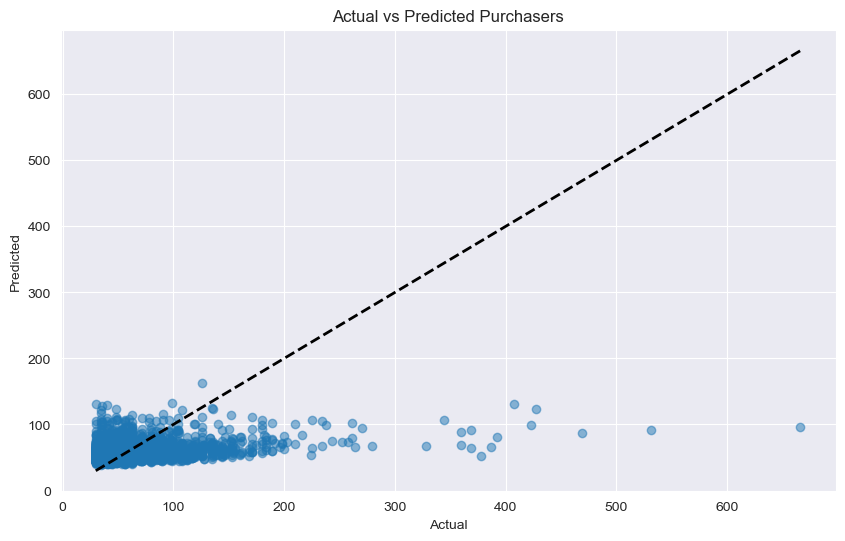

In [12]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values - diagonal line helps in visualizing how close the predictions are to the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Purchasers')
plt.show()


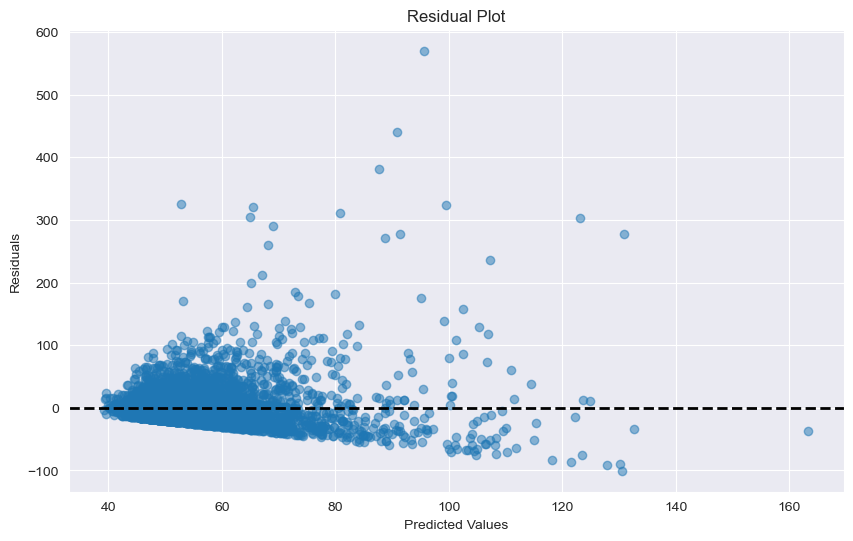

In [13]:
# Residual plot - shows the residuals on the vertical axis and the independent variable on the horizontal axis
# If the model is appropriate, the residuals should be randomly distributed around the horizontal axis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='k', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

C:\Users\vivek.jariwala\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


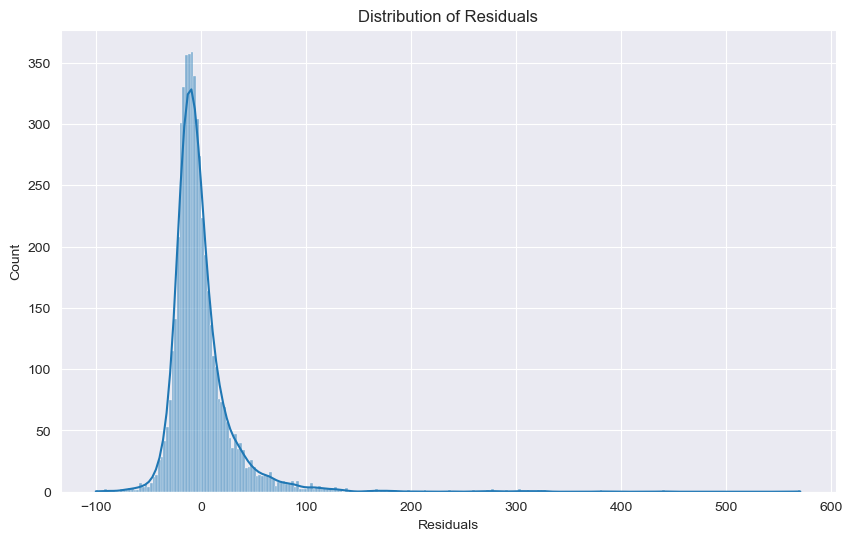

In [14]:
import seaborn as sns

# Histogram of residuals - can help check if the residuals are normally distributed
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

In [20]:
# Load the test set
test_data = pd.read_csv('data_test.csv')

# Trim spaces from column names
test_data.columns = test_data.columns.str.strip()

# Drop the 'purchasers' column if it exists
if 'purchasers' in test_data.columns:
    test_data = test_data.drop(columns=['purchasers'])

# Correct column names without spaces (if required)
test_column_names = ['index', 'restaurant_id', 'list_position', 'total_available_restaurants', 'estimate_delivery_time', 'menu_category', 'star_rating']

# Check if the number of columns match
if len(test_data.columns) == len(test_column_names):
    test_data.columns = test_column_names

# Feature Engineering on the test set
test_data['delivery_efficiency'] = test_data['estimate_delivery_time'] / (test_data['total_available_restaurants'] + 1)
test_data['position_ratio'] = test_data['list_position'] / (test_data['total_available_restaurants'] + 1)

# Predict using the best model
test_predictions = best_model.predict(test_data)

# Create a DataFrame with the required columns
output = pd.DataFrame({'index': test_data['index'], 'purchasers': test_predictions})

# Save the predictions to a CSV file
output.to_csv('predictions.csv', index=False)
